# line-profiler
`line_profiler` is a module for doing line-by-line profiling of functions for spotting bottlenecks in your code

In [1]:
%reload_ext line_profiler
import numpy as np

## Examples of usage

### bash %lprun command

In [2]:
def bar():
    a = np.random.random((3, 4))
    x = 10 * a
    return x

def foo():
    y = bar()
    z = 10 + y
    return z

%lprun -f foo foo()

Timer unit: 1e-07 s

Total time: 0.0112454 s
File: C:\Users\karol\AppData\Local\Temp\ipykernel_18396\815037871.py
Function: foo at line 6

Line #      Hits         Time  Per Hit   % Time  Line Contents
     6                                           def foo():
     7         1     112402.0 112402.0    100.0      y = bar()
     8         1         50.0     50.0      0.0      z = 10 + y
     9         1          2.0      2.0      0.0      return z

We see that the bottleneck is in `bar` called in `foo`. Let's see what happens there. We can use `%lprun` to profile the function `bar` inside `foo`.

In [3]:
%lprun -f bar foo()

Timer unit: 1e-07 s

Total time: 3.51e-05 s
File: C:\Users\karol\AppData\Local\Temp\ipykernel_18396\815037871.py
Function: bar at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def bar():
     2         1        200.0    200.0     57.0      a = np.random.random((3, 4))
     3         1        148.0    148.0     42.2      x = 10 * a
     4         1          3.0      3.0      0.9      return x

### using LineProfiler class

In [4]:
from line_profiler import LineProfiler
import random

def bar():
    a = np.random.random((3, 4))
    x = 10 * a
    return x

def foo():
    y = bar()
    z = 10 + y
    return z

lp = LineProfiler()
lp.add_function(foo)
lp.run('foo()')
lp.print_stats()

Timer unit: 1e-07 s

Total time: 4.6e-05 s
File: C:\Users\karol\AppData\Local\Temp\ipykernel_18396\321925748.py
Function: foo at line 9

Line #      Hits         Time  Per Hit   % Time  Line Contents
     9                                           def foo():
    10         1        423.0    423.0     92.0      y = bar()
    11         1         35.0     35.0      7.6      z = 10 + y
    12         1          2.0      2.0      0.4      return z



We see that the bottleneck is in `bar` called in `foo`. Let's see what happens there. We can use `LineProfiler` to profile the function `bar` inside `foo`.

In [5]:
lp.add_function(bar)
lp.run('foo()')
lp.print_stats()

Timer unit: 1e-07 s

Total time: 4.46e-05 s
File: C:\Users\karol\AppData\Local\Temp\ipykernel_18396\321925748.py
Function: bar at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                           def bar():
     5         1        242.0    242.0     54.3      a = np.random.random((3, 4))
     6         1        199.0    199.0     44.6      x = 10 * a
     7         1          5.0      5.0      1.1      return x

Total time: 9.96e-05 s
File: C:\Users\karol\AppData\Local\Temp\ipykernel_18396\321925748.py
Function: foo at line 9

Line #      Hits         Time  Per Hit   % Time  Line Contents
     9                                           def foo():
    10         2        915.0    457.5     91.9      y = bar()
    11         2         76.0     38.0      7.6      z = 10 + y
    12         2          5.0      2.5      0.5      return z



## Case study - random walker
Case based on [Easily Profile Python Code in Jupyter](https://mortada.net/easily-profile-python-code-in-jupyter.html) example.

Suppose you have a sequence of coordinates in (latitude / longitude) that represents a random walk from an origin. At each step the latitude and longitude change is determined by drawing from a Normal distribution:

In [6]:
import numpy as np
import pandas as pd
%reload_ext line_profiler

In [7]:
np.random.seed(1)
n = 100000

origin = {'lat': 51.1, 'lon': 17.1} # Wrocław

changes = np.random.randn(n, 2) /10

trace = pd.DataFrame.from_records(changes, columns=['lat', 'lon']).cumsum()
trace['lat'] += origin['lat']
trace['lon'] += origin['lon']

trace.head(10)

,lat,lon
0,51.262435,17.038824
1,51.209617,16.931527
2,51.296158,16.701374
3,51.470639,16.625253
4,51.502543,16.600316
5,51.648754,16.394302
6,51.616512,16.355896
7,51.729889,16.245907
8,51.712646,16.158121
9,51.716868,16.216403


We've got our random walk and we can plot it:

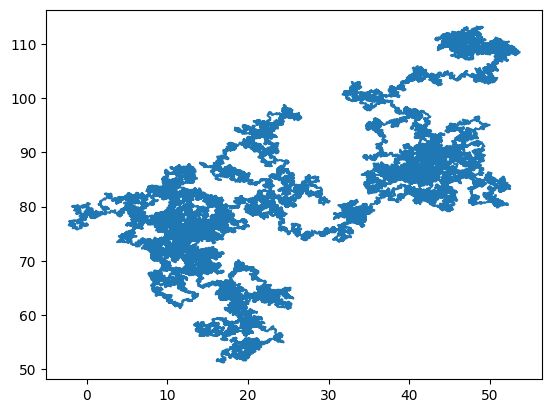

In [8]:
import matplotlib.pyplot as plt

plt.plot(trace.lon, trace.lat)
plt.show()

Suppose we want to know what was the biggest distance from the origin at any point in time. To calculate that we need to be able to calculate the distance between two points on the Earth's surface. We can use [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula) to calculate the distance between two points on the Earth's surface.

$$
d = 2r arcsin\left(\sqrt{\sin^2(\frac{\Delta\phi}{2}) + \cos(\phi_1)\cos(\phi_2)\sin^2(\frac{\Delta\lambda}{2})}\right)
$$
where $r$ is the radius of the Earth, $\phi$ is the latitude, $\lambda$ is the longitude and $\Delta\phi$ and $\Delta\lambda$ are the differences between the latitudes and longitudes.

In [ ]:
from math import radians, cos, sin, asin, sqrt

def haversine(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    """
    Calculate the distance between two points on the earth with given latitudes and longitudes of the two points and haversine formula.
    """
    earth_radius = 6367
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    temp = sin((lat2 - lat1) / 2)**2 + cos(lat1) * cos(lat2) * sin((lon2 - lon1) / 2)**2
    d = 2 * earth_radius * asin(sqrt(temp))
    return d

Test our haversine function with ipytest:

In [10]:
import ipytest
from pytest import approx
ipytest.autoconfig()

In [11]:
%%ipytest
def test_haversine():
    assert haversine(51.1, 17.1, 52.2, 18.2) == approx(143.851, abs=0.001)
    assert haversine(51.1, 17.1, 52.2, 18.2) == haversine(52.2, 18.2, 51.1, 17.1)

.                                                                                            [100%]
1 passed in 0.01s


With tested haversine function we can calculate the distance from the origin at any point in time:

In [13]:
def get_distances(trace, origin):
    distances = {}
    for i in trace.index:
        distances[i] = haversine(trace['lat'].loc[i], trace['lon'].loc[i], origin['lat'], origin['lon'])
    distances = pd.Series(distances)
    return distances

def get_farthest(trace, origin):
    distance = get_distances(trace, origin)
    max_idx = distance.argmax()
    return trace.loc[max_idx], distance.loc[max_idx]

get_farthest(trace, origin)

(lat    113.094531
 lon     47.094077
 Name: 97594, dtype: float64,
 np.float64(6648.791358150188))

In [16]:
%timeit -r3 -n5 get_farthest(trace, origin)

1.48 s ± 1.11 ms per loop (mean ± std. dev. of 3 runs, 5 loops each)


Not bad, but could be faster. Let's see what's the bottleneck.

In [17]:
%lprun -f get_farthest get_farthest(trace, origin)

Timer unit: 1e-07 s

Total time: 7.76522 s
File: C:\Users\karol\AppData\Local\Temp\ipykernel_18396\2835619839.py
Function: get_farthest at line 8

Line #      Hits         Time  Per Hit   % Time  Line Contents
     8                                           def get_farthest(trace, origin):
     9         1   77634951.0    8e+07    100.0      distance = get_distances(trace, origin)
    10         1       2612.0   2612.0      0.0      max_idx = distance.argmax()
    11         1      14654.0  14654.0      0.0      return trace.loc[max_idx], distance.loc[max_idx]

Problematic spot is `get_distances`. Let's see what's the bottleneck there.

In [21]:
%lprun -f get_distances get_farthest(trace, origin)

Timer unit: 1e-07 s

Total time: 7.8754 s
File: C:\Users\karol\AppData\Local\Temp\ipykernel_18396\2835619839.py
Function: get_distances at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def get_distances(trace, origin):
     2         1          4.0      4.0      0.0      distances = {}
     3    100001     646013.0      6.5      0.8      for i in trace.index:
     4    100000   77844665.0    778.4     98.8          distances[i] = haversine(trace['lat'].loc[i], trace['lon'].loc[i], origin['lat'], origin['lon'])
     5         1     263281.0 263281.0      0.3      distances = pd.Series(distances)
     6         1          5.0      5.0      0.0      return distances

The most problematic spot is `haversine`. Let's see what's the bottleneck there.

In [19]:
%lprun -f haversine get_farthest(trace, origin)

Timer unit: 1e-07 s

Total time: 0.274304 s
File: C:\Users\karol\AppData\Local\Temp\ipykernel_18396\2800141189.py
Function: haversine at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                           def haversine(lat1, lon1, lat2, lon2):
     4    100000     225654.0      2.3      8.2      earth_radius = 6367
     5    100000     673526.0      6.7     24.6      lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
     6    100000    1120956.0     11.2     40.9      temp = sin((lat2 - lat1) / 2)**2 + cos(lat1) * cos(lat2) * sin((lon2 - lon1) / 2)**2
     7    100000     518889.0      5.2     18.9      d = 2 * earth_radius * asin(sqrt(temp))
     8    100000     204017.0      2.0      7.4      return d

Total time of haversine execution time is only `0.274304 s` from total of total `7.8754 s`. This suggests that haversine is not a bottleneck per se, but the for loop that calls it is.

To fix the bottleneck we can vectorize haversine with numpy:

In [22]:
def haversine_vec(lat1, lon1, lat2, lon2):
    earth_radius = 6367
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    temp = np.sin((lat2 - lat1) / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin((lon2 - lon1) / 2)**2
    d = 2 * earth_radius * np.arcsin(np.sqrt(temp))
    return d

In [30]:
%%ipytest

def test_haversine_vec():
    assert haversine_vec(51.1, 17.1, 52.2, 18.2) == approx(143.851, abs=0.001)
    assert haversine_vec(51.1, 17.1, 52.2, 18.2) == haversine_vec(52.2, 18.2, 51.1, 17.1)

def test_haversine_vec_with_haversine():
    assert haversine_vec(51.1, 17.1, 52.2, 18.2) == approx(haversine(51.1, 17.1, 52.2, 18.2), abs=0.001)

def test_haversine_vec_with_vector():
    assert haversine_vec(51.1, 17.1,[52.2, 52.3], [18.2, 18.3]) == approx([143.851, 156.879], abs=0.001)

...                                                                                          [100%]
3 passed in 0.01s


With tested vectorized haversine function we can calculate the distance from the origin at any point in time:

In [32]:
def get_distances_vec(trace, origin):
    distances = haversine_vec(trace['lat'], trace['lon'], origin['lat'], origin['lon'])
    return distances

def get_farthest_vec(trace, origin):
    distance = get_distances_vec(trace, origin)
    max_idx = distance.argmax()
    return trace.loc[max_idx], distance.loc[max_idx]

In [52]:
%%ipytest

def test_get_farthest_vec():
    assert get_farthest_vec(trace, origin)[0].equals(get_farthest(trace, origin)[0])
    assert get_farthest_vec(trace, origin)[1] == approx(get_farthest(trace, origin)[1], abs=0.001)

.                                                                                            [100%]
1 passed in 2.95s


In [55]:
%timeit -r3 -n5 get_farthest_vec(trace, origin)

4.65 ms ± 462 μs per loop (mean ± std. dev. of 3 runs, 5 loops each)


From ~1.48 s to ~4.65 ms. That's over 300 times faster! That's a huge improvement!